In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# check to see if gpu support is available and use the gpu for computations if possible
device = ("cuda" if torch.cuda.is_available() else "cpu")

# Define basic Neural Network

In [12]:
# define the model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(2, 12)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(12, 12)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(12, 1)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x
    
model = NeuralNetwork().to(device)

# Classification Example

[[ 0.24413552 -0.81920501]
 [ 0.60829629  0.62572577]]


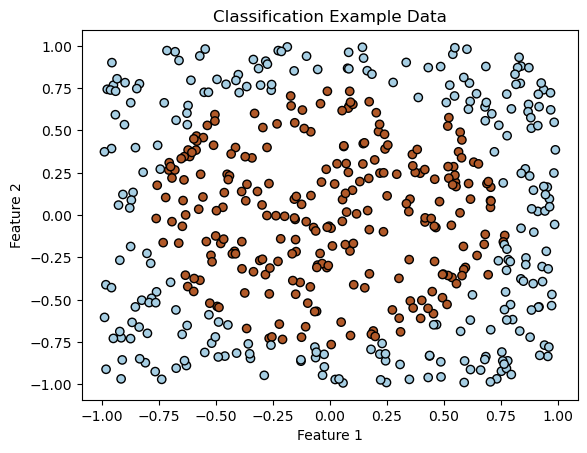

In [21]:
# load some example data taken from the machine learning and physics lecture
X = np.load('data03/data2d.npy')
y = np.load('data03/labels.npy')

plt.scatter(X[:, 0], X[:, 1], c = y, edgecolors = 'k', cmap = plt.cm.Paired)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Classification Example Data')
plt.show()

## Train NN as classifier

In [22]:
# turn data to torch tensors
if(isinstance(X, np.ndarray)):
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
else:
    X = X.to(device)
    y = y.to(device)

# train the model
model = model.to(device)
loss_fn   = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# one epoch means the whole dataset has been used once to train
n_epochs = 100
batch_size = 20

for epoch in range(n_epochs):
    current_loss = 0
    for i in range(0, len(X), batch_size):
        # train on parts of the whole dataset called batches
        Xbatch = X[i : i + batch_size]
        ybatch = y[i : i + batch_size]
        # calculate model prediction labels
        y_pred = model(Xbatch)
        # compare to true labels by calculating the loss
        loss = loss_fn(y_pred, ybatch)
        # reset the gradients from last iteration
        optimizer.zero_grad()
        # compute the new gradients
        loss.backward()
        # update the parameters according to the optimizer algorithm
        optimizer.step()


# compute accuracy
y_pred = model(X)
accuracy = (y_pred.round() == y).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.9980000257492065


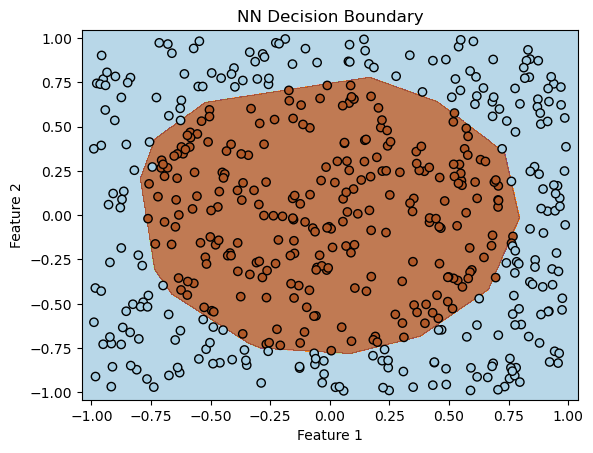

In [14]:
if(isinstance(X, torch.Tensor)):
    X = X.cpu().numpy()
    y = y.cpu().numpy()

xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 0.05, X[:, 0].max() + 0.05, 1000),
                     np.linspace(X[:, 1].min() - 0.05, X[:, 1].max() + 0.05, 1000))

Z = model.cpu()(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).round()
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z.detach(), cmap=plt.cm.Paired, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c = y, edgecolors='k', cmap=plt.cm.Paired)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('NN Decision Boundary')
plt.show()

# Add more layers to the NN

In [26]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self, n_layers = 5):
        super().__init__()
        
        #input Layer
        layers = [nn.Linear(2, 12), nn.ReLU()]
        
        #hidden Layers
        for i in range(n_layers):
            layers.append(nn.Linear(12, 12))
            layers.append(nn.ReLU())
        
        #output Layer
        layers.append(nn.Linear(12, 1))
        layers.append(nn.Sigmoid())
        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = self.layers(x)     
        return x
    
model = DeepNeuralNetwork(2).to(device)

In [24]:
def train_model(model, X, y, n_epochs = 100):
    # turn data to torch tensors
    if(isinstance(X, np.ndarray)):
        X = torch.tensor(X, dtype=torch.float32).to(device)
        y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1).to(device)
    else:
        X = X.to(device)
        y = y.to(device)


    # train the model
    model = model.to(device)
    loss_fn   = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    batch_size = 20

    loss_list = []
    epoch_list = []
    grad_first = []
    grad_last = []

    for epoch in range(n_epochs):
        current_loss = 0
        for i in range(0, len(X), batch_size):
            Xbatch = X[i : i + batch_size]
            y_pred = model(Xbatch)
            ybatch = y[i : i + batch_size]
            loss = loss_fn(y_pred, ybatch)
            current_loss = loss.data.cpu()
            optimizer.zero_grad()
            loss.backward()
            grad_first.append(np.mean(abs(model.layers[0].bias.grad.cpu().numpy())))
            grad_last.append(np.mean(abs(model.layers[-2].bias.grad.cpu().numpy())))
            optimizer.step()
        
        # evaluate 20 points to plot loss over training
        if(epoch % int(n_epochs / 20) == 0):
            epoch_list.append(epoch)
            loss_list.append(current_loss)

    # compute accuracy
    y_pred = model(X)
    accuracy = (y_pred.round() == y).float().mean()
    print(f"Accuracy {accuracy}")
    print(f"mean gradient of first layer: {np.mean(grad_first)}")
    print(f"mean gradient of last layer: {np.mean(grad_last)}")

    # plot loss over training epochs
    plt.plot(epoch_list, loss_list)
    plt.title("loss over training")
    plt.xlabel("# epochs")
    plt.ylabel("loss")
    plt.show()

Accuracy 0.9940000176429749
mean gradient of first layer: 0.04650842770934105
mean gradient of last layer: 0.012728228233754635


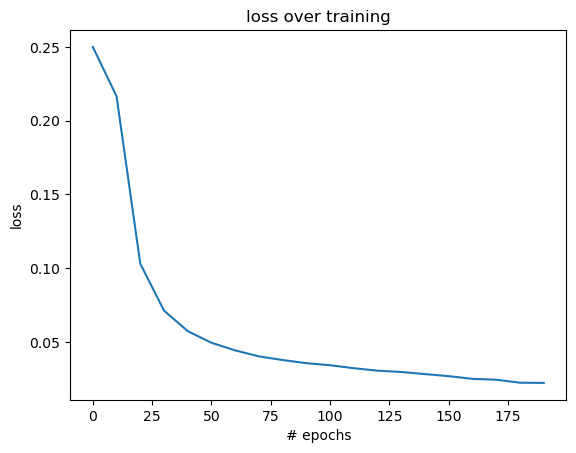

11.428776502609253


In [27]:
start = time.time()
train_model(DeepNeuralNetwork(2), X, y, n_epochs = 200)
print(time.time() - start)

Accuracy 0.5
mean gradient of first layer: 1.2947186589984047e-14
mean gradient of last layer: 0.052062664180994034


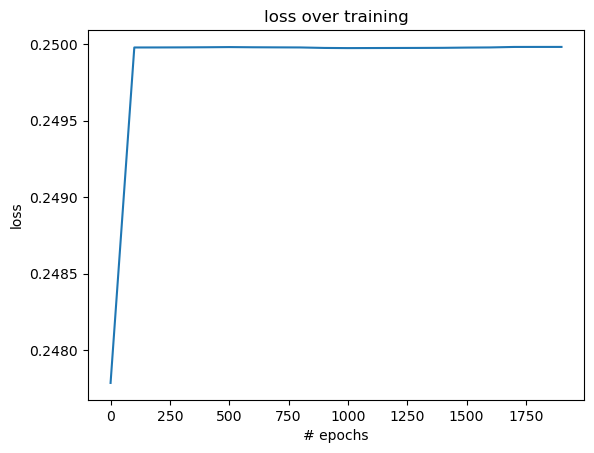

305.07241678237915


In [252]:
start = time.time()
train_model(DeepNeuralNetwork(25), X, y, n_epochs = 2000)
print(time.time() - start)